<a href="https://colab.research.google.com/github/mohammad2682/Car_Recognition/blob/main/Car_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Essentialies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter
import os
import pandas as pd
import cv2

from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import keras
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv2D, Input
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import BatchNormalization, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Installing kaggle to download the dataset

In [2]:
!pip install kaggle

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d abhishektyagi001/vehicle-make-model-recognition-dataset-vmmrdb

 99% 457M/462M [00:11<00:00, 38.9MB/s]
100% 462M/462M [00:11<00:00, 43.2MB/s]


In [ ]:
!unzip vehicle-make-model-recognition-dataset-vmmrdb.zip
!rm vehicle-make-model-recognition-dataset-vmmrdb.zip

In [6]:
!mkdir Dataset/test

In [7]:
!cp -r Dataset/SubsetVMMR/chevrolet_impala_2008 Dataset/test/chevrolet_impala_2008
!cp -r Dataset/SubsetVMMR/dodge_ram_1500_2001 Dataset/test/dodge_ram_2001
!cp -r Dataset/SubsetVMMR/ford_f150_2006 Dataset/test/ford_f150_2006
!cp -r Dataset/SubsetVMMR/gmc_sierra_1500_2012 Dataset/test/gmc_sierra_2012

!cp -r Dataset/SubsetVMMR/honda_accord_1997 Dataset/test/honda_accord_1997
!cp -r Dataset/SubsetVMMR/honda_civic_1998 Dataset/test/honda_civic_1998
!cp -r Dataset/SubsetVMMR/nissan_altima_2014 Dataset/test/nissan_altima_2014

!cp -r Dataset/SubsetVMMR/chevrolet_silverado_2004 Dataset/test/chevrolet_silverado_2004
!cp -r Dataset/SubsetVMMR/toyota_camry_2014 Dataset/test/toyota_camry_2014
!cp -r Dataset/SubsetVMMR/toyota_corolla_2013 Dataset/test/toyota_corolla_2013

In [8]:
!mv Dataset/Most_Stolen_Cars Dataset/train

# Preparing Train and Test data

In [9]:
train_dir = 'Dataset/train'
test_dir = 'Dataset/test'
classes = os.listdir(train_dir)
print(classes)
for class_name in classes:
  print('class ', class_name, ' have ', len(os.listdir(os.path.join(train_dir, class_name))), ' train data')
  print('class ', class_name, ' have ', len(os.listdir(os.path.join(test_dir, class_name))), ' test data')

['honda_accord_1997', 'honda_civic_1998', 'chevrolet_impala_2008', 'nissan_altima_2014', 'ford_f150_2006', 'chevrolet_silverado_2004', 'toyota_corolla_2013', 'toyota_camry_2014', 'gmc_sierra_2012', 'dodge_ram_2001']
class  honda_accord_1997  have  647  train data
class  honda_accord_1997  have  355  test data
class  honda_civic_1998  have  812  train data
class  honda_civic_1998  have  443  test data
class  chevrolet_impala_2008  have  875  train data
class  chevrolet_impala_2008  have  346  test data
class  nissan_altima_2014  have  342  train data
class  nissan_altima_2014  have  52  test data
class  ford_f150_2006  have  879  train data
class  ford_f150_2006  have  318  test data
class  chevrolet_silverado_2004  have  815  train data
class  chevrolet_silverado_2004  have  487  test data
class  toyota_corolla_2013  have  285  train data
class  toyota_corolla_2013  have  85  test data
class  toyota_camry_2014  have  330  train data
class  toyota_camry_2014  have  60  test data
class  

In [10]:
img_width = 244
img_height = 244
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5911 files belonging to 10 classes.
Using 4729 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5911 files belonging to 10 classes.
Using 1182 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['chevrolet_impala_2008', 'chevrolet_silverado_2004', 'dodge_ram_2001', 'ford_f150_2006', 'gmc_sierra_2012', 'honda_accord_1997', 'honda_civic_1998', 'nissan_altima_2014', 'toyota_camry_2014', 'toyota_corolla_2013']


# Plot some samples

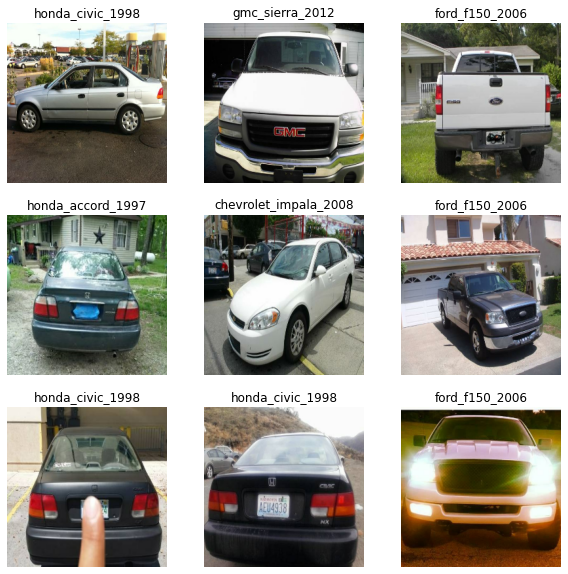

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 244, 244, 3)
(32,)


# Preprocessing data

In [15]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


# Creating CNN Model

In [19]:
num_classes = 10

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [20]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


148/148 [==============================] - 47s 117ms/step - loss: 2.2600 - accuracy: 0.2146 - val_loss: 2.0608 - val_accuracy: 0.2707
Epoch 2/20
148/148 [==============================] - 14s 91ms/step - loss: 1.8784 - accuracy: 0.3322 - val_loss: 1.9660 - val_accuracy: 0.3156
Epoch 3/20
148/148 [==============================] - 13s 91ms/step - loss: 1.5831 - accuracy: 0.4354 - val_loss: 1.8558 - val_accuracy: 0.3350
Epoch 4/20
148/148 [==============================] - 13s 91ms/step - loss: 1.2574 - accuracy: 0.5506 - val_loss: 1.8438 - val_accuracy: 0.3359
Epoch 5/20
148/148 [==============================] - 13s 91ms/step - loss: 1.0204 - accuracy: 0.6302 - val_loss: 1.8597 - val_accuracy: 0.3545
Epoch 6/20
148/148 [==============================] - 14s 91ms/step - loss: 0.8201 - accuracy: 0.7035 - val_loss: 1.9035 - val_accuracy: 0.3528
Epoch 7/20
148/148 [==============================] - 13s 91ms/step - loss: 0.6626 - accuracy: 0.7649 - val_loss: 1.8694 - val_accuracy: 0.3570
Ep

# Transfer learning

## Using ResNet34

In [12]:
# Training transform includes random rotation and flip to build a more robust model
train_transforms = transforms.Compose([transforms.Resize((244,244)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# The validation set will use the same transform as the test set
test_transforms = transforms.Compose([transforms.Resize((244,244)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

validation_transforms = transforms.Compose([transforms.Resize((244,244)),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

train_data, valid_data = torch.utils.data.random_split(train_data, [5000, 911])

# Using the image datasets and the trainforms, define the dataloaders
# The trainloader will have shuffle=True so that the order of the images do not affect the model
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1024, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)

In [22]:
model = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [23]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [25]:
# Implement a function for the validation pass
def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    
    # change model to work with cuda
    model.to('cuda')

    # Iterate over data from validloader
    for ii, (images, labels) in enumerate(validloader):
    
        # Change images and labels to work with cuda
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass image though model for prediction
        output = model.forward(images)
        # Calculate loss
        valid_loss += criterion(output, labels).item()
        # Calculate probability
        ps = torch.exp(output)
        
        # Calculate accuracy
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return valid_loss, accuracy

In [26]:
epochs = 20
steps = 0
print_every = 40

# change to gpu mode
model.to('cuda')
model.train()
for e in range(epochs):

    running_loss = 0
    
    # Iterating over data to carry out training step
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        # zeroing parameter gradients
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Carrying out validation step
        if steps % print_every == 0:
            # setting model to evaluation mode during validation
            model.eval()
            
            # Gradients are turned off as no longer in training
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)
            
            print(f"No. epochs: {e+1}, \
            Training Loss: {round(running_loss/print_every,3)} \
            Valid Loss: {round(valid_loss/len(validloader),3)} \
            Valid Accuracy: {round(float(accuracy/len(validloader)),3)}")
            
            
            # Turning training back on
            model.train()
            lrscheduler.step(accuracy * 100)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


No. epochs: 1,             Training Loss: 1.549             Valid Loss: 0.726             Valid Accuracy: 0.709
No. epochs: 2,             Training Loss: 0.457             Valid Loss: 0.559             Valid Accuracy: 0.812
No. epochs: 3,             Training Loss: 0.327             Valid Loss: 0.32             Valid Accuracy: 0.89
No. epochs: 4,             Training Loss: 0.173             Valid Loss: 0.316             Valid Accuracy: 0.89
No. epochs: 5,             Training Loss: 0.101             Valid Loss: 0.222             Valid Accuracy: 0.923
No. epochs: 6,             Training Loss: 0.06             Valid Loss: 0.171             Valid Accuracy: 0.944
No. epochs: 7,             Training Loss: 0.045             Valid Loss: 0.161             Valid Accuracy: 0.946
No. epochs: 8,             Training Loss: 0.041             Valid Loss: 0.167             Valid Accuracy: 0.939
No. epochs: 9,             Training Loss: 0.034             Valid Loss: 0.142             Valid Accuracy: 0.

In [13]:
import torch
from torchvision import datasets, models, transforms
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Saving trained model

In [29]:
model_save_name = 'Car_detect.h5'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model, path)

## Loading model

In [14]:
model_save_name = 'Car_detect.h5'
path = F"/content/gdrive/My Drive/{model_save_name}" 
model = torch.load(path)

## Accuracy on test

In [15]:
correct = 0
total = 0
model.to('cuda')


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        # Get probabilities
        outputs = model(images)
        # Turn probabilities into predictions
        _, predicted_outcome = torch.max(outputs.data, 1)
        # Total number of images
        total += labels.size(0)
        # Count number of cases in which predictions are correct
        correct += (predicted_outcome == labels).sum().item()

print(f"Test accuracy of model: {round(100 * correct / total,3)}%")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test accuracy of model: 97.674%


In [16]:
x_test,y_test = next(iter(testloader))
x_test,y_test = x_test.to('cuda'), y_test.to('cuda')
with torch.no_grad():
  outputs = model(x_test)
  _, y_pred = torch.max(outputs.data, 1)
  print('accuracy of the model on test set : ',(((y_pred == y_test).sum())/float(y_pred.shape[0])).item(),"%")

accuracy of the model on test set :  0.9775390625 %


In [17]:
preds = y_pred.cpu().detach().numpy()
labels_test = y_test.cpu().detach().numpy()

## Confusion matrix

Text(0.5, 144.41374999999996, 'Predicted')

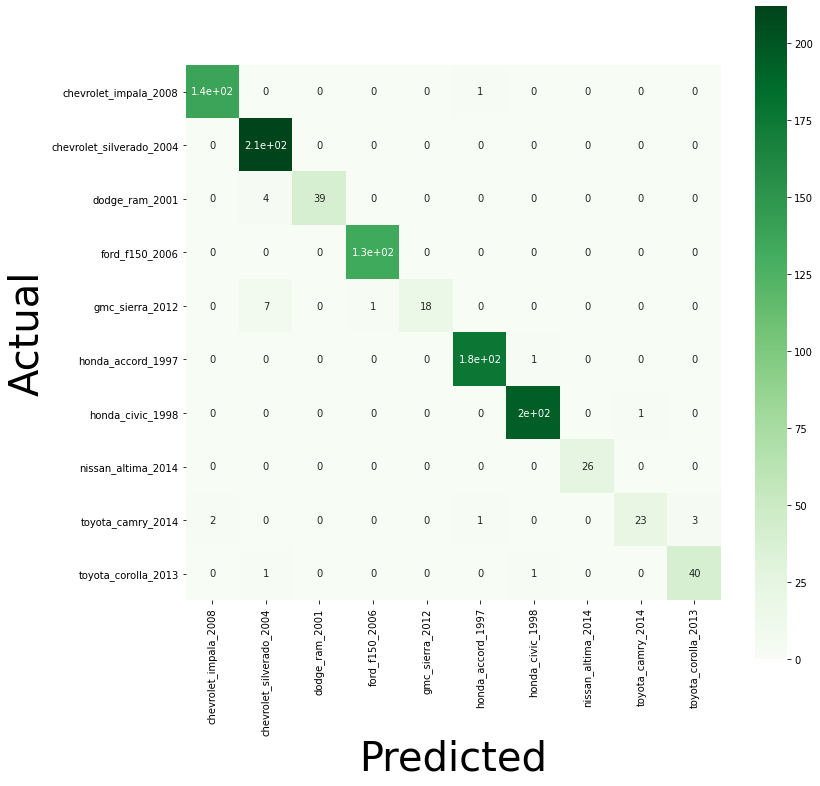

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(preds,labels_test)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=class_names, yticklabels=class_names)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

## Displaying Predicted car

In [19]:
def process_image(image):
    
    # Process a PIL image for use in a PyTorch model

    # Converting image to PIL image using image file path
    pil_im = Image.open(f'{image}' + '.jpg')

    # Building image transform
    transform = transforms.Compose([transforms.Resize((244,244)),
                                    #transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]) 
    
    # Transforming image for use with network
    pil_tfd = transform(pil_im)
    
    # Converting to Numpy array 
    array_im_tfd = np.array(pil_tfd)
    
    return array_im_tfd

In [48]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
        
    return ax

In [38]:
def predict(image_path, model, topk=5):
    # Implement the code to predict the class from an image file   
    model = model.cpu()
    # Loading model - using .cpu() for working with CPUs
    #loaded_model = load_checkpoint(model).cpu()
    # Pre-processing image
    img = process_image(image_path)
    # Converting to torch tensor from Numpy array
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Adding dimension to image to comply with (B x C x W x H) input of model
    img_add_dim = img_tensor.unsqueeze_(0)

    # Setting model to evaluation mode and turning off gradients
    model.eval()
    with torch.no_grad():
        # Running image through network
        output = model(img_add_dim)
        
    #conf, predicted = torch.max(output.data, 1)   
    probs_top = output.topk(topk)[0]
    predicted_top = output.topk(topk)[1]
    
    # Converting probabilities and outputs to lists
    conf = np.array(probs_top)[0]
    predicted = np.array(predicted_top)[0]
        
    #return probs_top_list, index_top_list
    return conf, predicted

In [23]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(test_dir)
print(classes, c_to_idx)

['chevrolet_impala_2008', 'chevrolet_silverado_2004', 'dodge_ram_2001', 'ford_f150_2006', 'gmc_sierra_2012', 'honda_accord_1997', 'honda_civic_1998', 'nissan_altima_2014', 'toyota_camry_2014', 'toyota_corolla_2013'] {'chevrolet_impala_2008': 0, 'chevrolet_silverado_2004': 1, 'dodge_ram_2001': 2, 'ford_f150_2006': 3, 'gmc_sierra_2012': 4, 'honda_accord_1997': 5, 'honda_civic_1998': 6, 'nissan_altima_2014': 7, 'toyota_camry_2014': 8, 'toyota_corolla_2013': 9}


In [32]:
def plot_solution(cardir, model):
  # Testing predict function
  image_path = cardir
  # Inputs are paths to saved model and test image
  carname = cardir.split('/')[2]

  conf2, predicted1 = predict(image_path, model, topk=5)
  # Converting classes to names
  names = []
  for i in range(5):
  
      names += [classes[predicted1[i]]]


  # Creating PIL image
  image = Image.open(image_path+'.jpg')

  # Plotting test image and predicted probabilites
  f, ax = plt.subplots(2,figsize = (6,10))

  ax[0].imshow(image)
  ax[0].set_title(carname)

  y_names = np.arange(len(names))
  ax[1].barh(y_names, conf2/conf2.sum(), color='darkblue')
  ax[1].set_yticks(y_names)
  ax[1].set_yticklabels(names)
  ax[1].invert_yaxis() 

  plt.show()

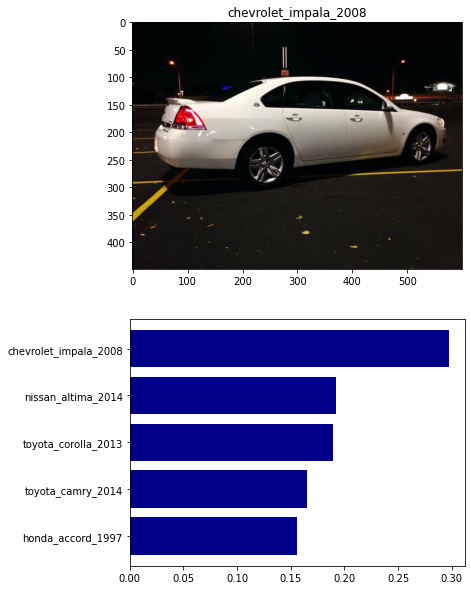

In [47]:
image_path = test_dir + '/chevrolet_impala_2008/00000_8xV8B4TpKMW_600x450'

plot_solution(image_path, model)